# Load packages

In [1]:
import ast
import numpy as np
import pandas as pd
import os, errno
import datetime
import uuid
import itertools
import yaml
import subprocess
import scipy.sparse as sp
from datasets import load_dataset
from scipy.sparse import csr_matrix
from scipy.spatial.distance import squareform
from sklearn.decomposition import non_negative_factorization
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import sparsefuncs
from scipy.cluster.hierarchy import leaves_list
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scanpy as sc
import anndata as ad
%matplotlib inline
from scipy.io import mmread
from IPython.display import Image
import anndata
import seaborn as sns
import scvi
from scvi.external import MRVI as MrVI

# Upload Data

In [2]:
# read in the h5ad file
# use gsutil to download file directly
f = "bionemo2/20250213.Tahoe.merged.pseudobulk.public.h5ad"
adata = sc.read_h5ad(f)
adata

AnnData object with n_obs × n_vars = 67018 × 62710
    obs: 'sample', 'drugname_drugconc', 'drug', 'n_cells', 'tscp_count', 'plate', 'Cell_Name_Vevo', 'Cell_ID_Cellosaur'
    var: 'gene_id', 'genome'

In [3]:
adata.shape

(67018, 62710)

In [4]:
adata.obs.value_counts('drugname_drugconc')

drugname_drugconc
[('DMSO_TF', 0.0, 'uM')]                       1400
[('Adagrasib', 0.05, 'uM')]                     800
[('Afatinib', 5.0, 'uM')]                       150
[('Afatinib', 0.5, 'uM')]                       150
[('Afatinib', 0.05, 'uM')]                      150
                                               ... 
[('LY-2584702 (tosylate salt)', 0.5, 'uM')]      49
[('SBI-0640756', 0.5, 'uM')]                     48
[('Belzutifan', 0.05, 'uM')]                     48
[('Erdafitinib ', 0.5, 'uM')]                    46
[('Encorafenib', 0.5, 'uM')]                     36
Name: count, Length: 1138, dtype: int64

In [7]:
import ast

adata.obs['dose'] = adata.obs['drugname_drugconc'].apply(
        lambda x: str(ast.literal_eval(x)[0][1]) if pd.notna(x) else 'NA'
    )

adata.obs['dose'] = adata.obs['dose'].apply(
    lambda x: pd.to_numeric(x) if pd.notna(x) else x
)

adata.obs['cell_drug'] = (
    adata.obs['Cell_Name_Vevo'].astype(str) + '_' +
    adata.obs['drug'].astype(str)
)

adata.obs.head()

,sample,drugname_drugconc,drug,n_cells,tscp_count,plate,Cell_Name_Vevo,Cell_ID_Cellosaur,dose,cell_drug
0,smp_1975,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,3076,6686156.0,6,A549,CVCL_0023,5.0,A549_8-Hydroxyquinoline
1,smp_1975,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,1505,4744833.0,6,HS-578T,CVCL_0332,5.0,HS-578T_8-Hydroxyquinoline
2,smp_1975,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,1700,2494504.0,6,HCT15,CVCL_0292,5.0,HCT15_8-Hydroxyquinoline
3,smp_1975,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,3560,8923357.0,6,HOP62,CVCL_1285,5.0,HOP62_8-Hydroxyquinoline
4,smp_1975,"[('8-Hydroxyquinoline', 5.0, 'uM')]",8-Hydroxyquinoline,1876,4676765.0,6,SK-MEL-2,CVCL_0069,5.0,SK-MEL-2_8-Hydroxyquinoline


In [10]:
# Filter the AnnData object where the dose is 0, 0.5 or 5
adata_mini = adata[adata.obs['dose'].isin([0,0.5,5])].copy()
adata_mini

AnnData object with n_obs × n_vars = 45975 × 62710
    obs: 'sample', 'drugname_drugconc', 'drug', 'n_cells', 'tscp_count', 'plate', 'Cell_Name_Vevo', 'Cell_ID_Cellosaur', 'dose', 'cell_drug'
    var: 'gene_id', 'genome'

<Axes: xlabel='count', ylabel='Count'>

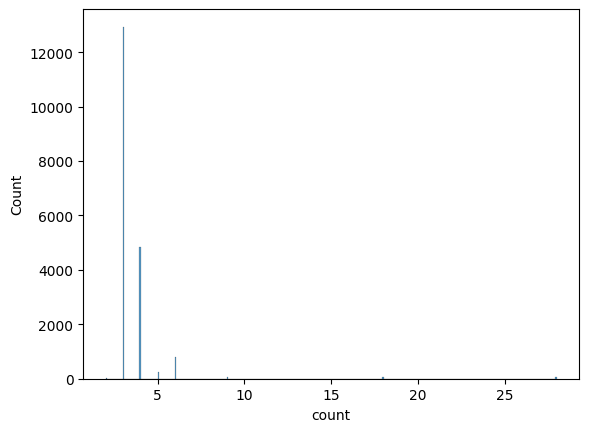

In [11]:
sns.histplot(adata.obs['cell_drug'].value_counts())

In [13]:
adata.obs['cell_drug'].value_counts().tail()

cell_drug
NCI-H661_Erdafitinib     2
SW 1271_Belzutifan       2
H4_Encorafenib           2
NCI-H2122_Belzutifan     2
SK-MEL-2_Encorafenib     2
Name: count, dtype: int64

# Feature selection

In [ ]:
'''
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    hvg_union = set()
    for c in np.unique(adata.obs['cell_line']):
        for d in np.unique(adata.obs['drug']):
            adata_temp = adata[(adata.obs['cell_line'] == c) & (adata.obs['drug'] == d)]
            sc.pp.log1p(adata_temp)
            sc.pp.highly_variable_genes(adata_temp,
                                        flavor='seurat',
                                        n_top_genes=200,
                                        inplace=True,
                                        subset=True)
            hvg_union = hvg_union.union(set(adata_temp.var_names))
    print(len(hvg_union))
'''

In [14]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

    hvg_union = set()
    for c in np.unique(adata_mini.obs['Cell_Name_Vevo']):
            adata_temp = adata_mini[(adata_mini.obs['Cell_Name_Vevo'] == c)]
            sc.pp.log1p(adata_temp)
            sc.pp.highly_variable_genes(adata_temp,
                                        flavor='seurat',
                                        n_top_genes=200,
                                        inplace=True,
                                        subset=True)
            hvg_union = hvg_union.union(set(adata_temp.var_names))
            print(len(hvg_union))
    print(len(hvg_union))

200
377
513
628
768
863
977
1054
1165
1233
1328
1430
1488
1562
1636
1676
1722
1761
1841
1883
1918
1960
1979
2023
2064
2100
2140
2201
2235
2350
2410
2445
2482
2594
2674
2701
2714
2782
2805
2850
2880
2926
2936
2993
3028
3050
3081
3107
3125
3143
3143


In [15]:
hvg_list = list(hvg_union)
df = pd.DataFrame(hvg_list, columns=['genes'])
df.to_csv('pseudobulk/pseudobulk_200_hvg_union.csv', index=False)

In [16]:
adata_mini = adata_mini[:,list(hvg_union)]
adata_mini

View of AnnData object with n_obs × n_vars = 45975 × 3143
    obs: 'sample', 'drugname_drugconc', 'drug', 'n_cells', 'tscp_count', 'plate', 'Cell_Name_Vevo', 'Cell_ID_Cellosaur', 'dose', 'cell_drug'
    var: 'gene_id', 'genome'

# Fit the model

In [7]:
# batch_key = 'replicate'
sample_key = 'cell_drug'
batch_key = "plate"
labels_key = None


MrVI.setup_anndata(adata_mini,
                   sample_key=sample_key,
                   batch_key=batch_key)

/usr/local/lib/python3.12/dist-packages/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 2417 in adata.obs['_scvi_sample'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [9]:
model = MrVI(adata_mini)
model.train(accelerator='cpu',
            early_stopping=True,
            max_epochs=400)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=29` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=29` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:368: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Monitored metric elbo_validation did not improve in the last 15 records. Best score: 4328.460. Signaling Trainer to stop.


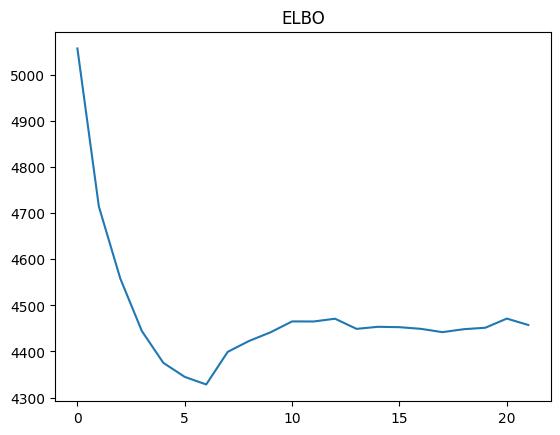

In [10]:
plt.plot(model.history["elbo_validation"])
plt.title("ELBO")
plt.show()

In [23]:
adata_mini.obs.value_counts(sample_key)

cell_drug
NCI-H596_DMSO_TF                       28
CHP-212_DMSO_TF                        28
HT-29_DMSO_TF                          28
HS-578T_DMSO_TF                        28
SNU-423_DMSO_TF                        28
                                       ..
Hs 766T_Encorafenib                     1
NCI-H2347_Encorafenib                   1
NCI-H661_Encorafenib                    1
NCI-H23_Encorafenib                     1
NCI-H596_LY-2584702 (tosylate salt)     1
Name: count, Length: 19000, dtype: int64

In [11]:
model.save(dir_path='pseudobulk/tahoe_pseudobulk_cell_drug_group_attention',
           overwrite=True,
           save_anndata=True)

In [2]:
# reloading data if restarting session
# adata_mini = sc.read_h5ad('pseudobulk/tahoe_pseudobulk_cell_drug_group_attention/adata.h5ad')

In [ ]:
'''
# reloading data if restarting session

model = MrVI.load(
    dir_path='pseudobulk/tahoe_pseudobulk_cell_drug_group_attention/',
    adata=adata_mini,
    accelerator='cpu'
)
model
'''

# Get latent representations

In [ ]:
# from scvi.model.utils import mde

u = model.get_latent_representation(give_z=False)
adata_mini.obsm["u"] = u
sc.pp.neighbors(adata_mini, use_rep="u")
sc.tl.umap(adata_mini, min_dist=0.3)


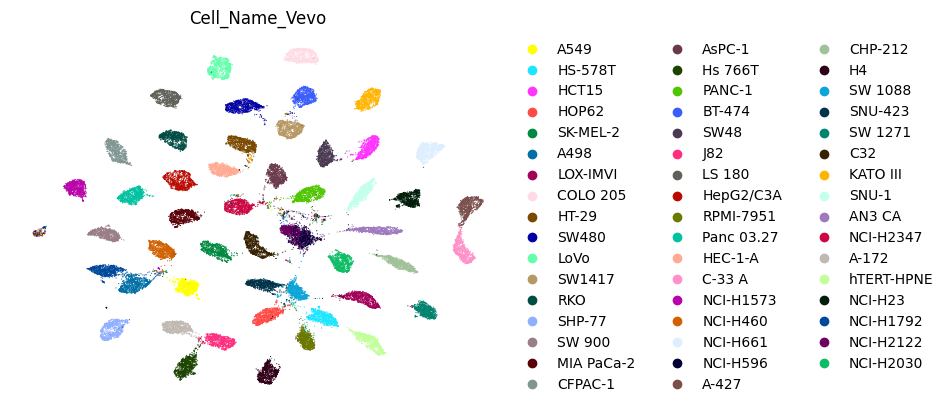

In [19]:
sc.pl.umap(
    adata_mini,  
    color=["Cell_Name_Vevo"],
    frameon=False,
    ncols=1,
)

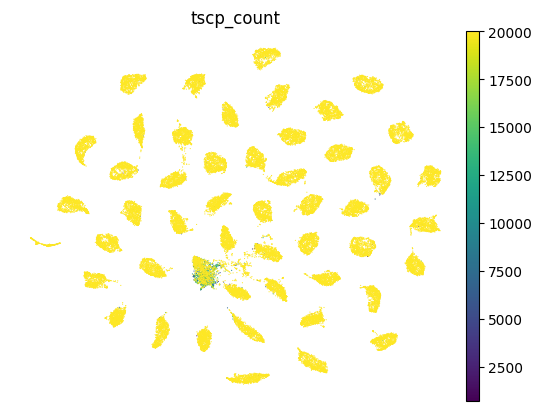

In [32]:
sc.pl.umap(
    adata_mini,  
    color=["tscp_count"],
    frameon=False,
    ncols=1,
    vmax = 20000
)

In [21]:
# save sample-sample dist matrix
np.savetxt("pseudobulk/tahoe_pseudobulk_MrVI_u_factor.csv", u, delimiter=",")

In [20]:
# save sample-sample dist matrix
u

array([[ 0.77663153, -0.17492875,  0.36359406, ..., -0.6497711 ,
        -1.0775073 , -0.25748   ],
       [ 1.2729373 , -0.4359215 ,  0.91905713, ..., -0.03701045,
        -0.7487426 ,  1.8536743 ],
       [-0.05153788,  0.18612723, -0.22573926, ...,  0.42587176,
        -0.7238813 ,  0.03716336],
       ...,
       [ 0.9648862 , -0.06311283,  0.3446111 , ..., -0.39984015,
        -1.1102326 , -0.11361952],
       [ 1.4985671 , -0.78019047, -0.32249483, ..., -0.16320528,
        -0.86681104,  0.18040067],
       [ 0.09004347,  1.0714169 ,  0.4429796 , ..., -0.34745464,
        -0.93395984, -0.26918322]], dtype=float32)

In [22]:
z = model.get_latent_representation(give_z=True)
adata_mini.obsm["z"] = z
sc.pp.neighbors(adata_mini, use_rep="z")
sc.tl.umap(adata_mini, min_dist=0.3)

100%|█████████████████████████████████| 360/360 [00:04<00:00, 76.21it/s]


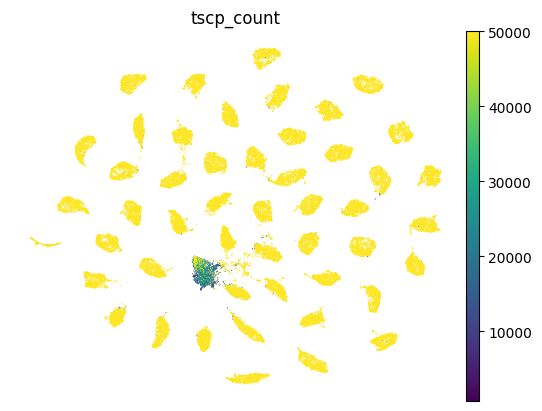

In [35]:
sc.pl.umap(
    adata_mini,
    color=["tscp_count"],
    frameon=False,
    ncols=1,
    vmax = 50000
)

In [ ]:
adata_mini.uns['drug_colors']

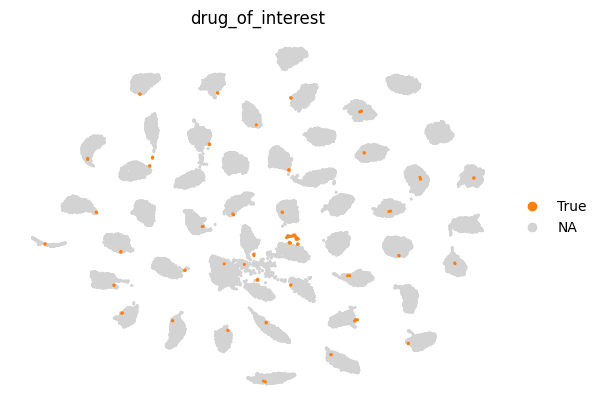

In [43]:
adata_mini.obs['drug_of_interest'] = (adata_mini.obs['drug'] == "Panobinostat").astype(str)

sc.pl.umap(
    adata_mini,
    color=["drug_of_interest"],
    size = 20,
    frameon=False,
    groups=['True'],
    ncols=1,
)

# Cell distances

In [7]:
# Compute local sample representations
cell_reps = model.get_local_sample_representation(adata_mini)

100%|███████████████████████████████████| 18/18 [03:26<00:00, 11.47s/it]


In [ ]:
import xarray as xr

batch_key = 'plate'
sample_key = 'cell_drug'
labels_key = None

cell_dists = model.get_local_sample_distances(
        adata_mini,
        use_mean=True,
        normalize_distances=False,
        keep_cell=False,
        groupby=sample_key, 
        use_vmap = False
    )

# save dists
cell_dists.to_netcdf("pseudobulk/tahoe_pseudobulk_cell_dists_namedosesample_attention.nc")

  5%|█▊                                | 4/75 [03:42<1:05:27, 55.32s/it]

In [ ]:
# create a DataFrame for mean sample-sample distances across all cells

drug_dist_df = pd.DataFrame(
        cell_dists['time_mut_dose'].mean(axis=0),
        columns = cell_dists['sample_x'].values,
        index = cell_dists['sample_x'].values
)
drug_dist_df
drug_dist_df.to_csv('pseudobulk/tahoe_pseudobulk_cell_dists_namedosesample_attention.csv')